<a href="https://colab.research.google.com/github/torrhen/cable_temperature_prediction/blob/master/cable_temperature_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data GitHub URL
DATA_CSV_URL = "https://raw.githubusercontent.com/torrhen/cable_temperature_prediction/master/cable.csv"

In [ ]:
import os
# create new project folder
os.makedirs('cable_temperature_prediction', exist_ok=True)

In [ ]:
import torch
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## cable_temperature_prediction/data.py

In [ ]:
#%writefile cable_temperature_prediction/data.py
import pandas as pd
import datetime as dt
import numpy as np
import torch

STANDARD_DEVIATION_OUTLIER_THRESHOLD = 2
ROUNDING_PRECISION = 3

# create dataframe from raw data taken from GitHub repository
def create_dataframe(url):
  # set the timestamp column as the index of the dataframe
  df = pd.read_csv(url, index_col=0, parse_dates=[0], infer_datetime_format=True)
  # resample data to ensure no missing timestamps
  df = df.resample("30min").mean()
  # replace all nan values using the last valid observation for every column
  df = df.pad() # pad() is equivalent to fillna(method="ffill")
  df = df.round(ROUNDING_PRECISION)
  # remove values outside 2 SD of the mean of each calendar month
  df = remove_outliers(df)
  
  return df

# group data by calendar month and replace values outside 2 SD of the mean with the last valid observed value for every column
def remove_outliers(df):
  # add new column string the integer month of each timestamp
  df["month"] = df.index.month

  # replace data points beyond 2 SD of the mean for each calendar month with np.nan
  def remove_data(group, std):
    group[np.abs(group - group.mean()) > std * group.std()] = np.nan
    return group

  transformed_df = df.groupby("month", as_index=False).transform(lambda x: remove_data(x, STANDARD_DEVIATION_OUTLIER_THRESHOLD))
  # fill empty data with the last valid observation for all columns
  transformed_df = transformed_df.fillna(method="ffill").round(ROUNDING_PRECISION)
  # remove integer month column
  df.drop(columns=["month"], inplace=True)

  return transformed_df


In [ ]:
# create dataframe from data downloaded from GitHUb
df = create_dataframe(DATA_CSV_URL)

In [ ]:
# create a new feature using the mean of each phase of the current load
phase_df = df[['Phase (Blue)', 'Phase (Yellow)', 'Phase (Red)']]
df['Load'] = phase_df.mean(axis=1).round(3)

In [ ]:
# drop features that are not necessary for training
X_df = df.drop(['Thermocouple 4', 'Thermocouple 6', 'Thermocouple 7', 'Phase (Blue)', 'Phase (Yellow)', 'Phase (Red)', 'Air Temperature'], axis=1)

In [ ]:
# create a new dataframe of the target feature to predict
y_df = X_df.pop('Thermocouple 5')
# the targets to predict will be shifted 1 time interval ahead
y_df = y_df[1:]
# convert to numpy array
y = y_df.values

In [ ]:
# ensure the shifted target for the final data point does not fall beyond the end of the dataframe
X_df = X_df[:-1]
# convert to numpy array
X = X_df.values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# split the sequential data into training and test dataframes without shuffling 
train_X, test_X, train_y, test_y = train_test_split(X,  y, test_size=0.5, shuffle=False)

# normalize data
normalizer = MinMaxScaler()
# fit normalizer to training data
train_X = normalizer.fit_transform(train_X)
# normalize test data using the same training data normalizer transform
test_X = normalizer.transform(test_X)

In [ ]:
from torch.utils.data import Dataset

# custom data set for pytorch
class CableDataset(Dataset):
  def __init__(self, X, y, sequence_length):
    super(CableDataset, self).__init__()
    assert(len(X) == len(y))
    self.sequence_length = sequence_length
    # convert numpy X and y data into sequence tensors
    self.X, self.y = self.create_sequences(torch.from_numpy(X).type(torch.float32), torch.from_numpy(y).type(torch.float32).unsqueeze(dim=-1))

  def create_sequences(self, X, y):
    X_ = torch.stack([X[i:i + self.sequence_length] for i in range(X.shape[0] - self.sequence_length)])
    # y_ = torch.stack([y[i + 1:i + self.sequence_length + 1] for i in range(y.shape[0] - self.sequence_length)])
    y_ = torch.stack([y[i + 1] for i in range(y.shape[0] - self.sequence_length)])
    return X_, y_

  # override
  def __len__(self):
    return len(self.X)
    
  # override
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
SEQUENCE_LENGTH = 8

# create custom pytorch training and test data tensors
train_data = CableDataset(train_X, train_y, SEQUENCE_LENGTH)
test_data = CableDataset(test_X, test_y, SEQUENCE_LENGTH)

print(f"Train X shape: {train_data.X.shape}")
print(f"Train y shape: {train_data.y.shape}")
print(f"Test X shape: {test_data.X.shape}")
print(f"Test y shape: {test_data.y.shape}")

Train X shape: torch.Size([4791, 8, 4])
Train y shape: torch.Size([4791, 1])
Test X shape: torch.Size([4792, 8, 4])
Test y shape: torch.Size([4792, 1])


In [ ]:
from torch.utils.data import DataLoader

# divide the training and test data into batches without shuffling since data is sequential.
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

print(f'Train data loader contains {len(train_data)} samples within {len(train_dataloader)} batches')
print(f'Test data loader contains {len(test_data)} samples within {len(test_dataloader)} batches')

Train data loader contains 4791 samples within 150 batches
Test data loader contains 4792 samples within 150 batches


## cable_temperature_prediction/models.py

In [71]:
from torch import nn

class PositionalEncoding(nn.Module):
  '''
  Transformer Positional Encoding

  Args:
      sequence_dim (int): size of input sequence
      embedding_dim (int): size of input embedding

  '''
  def __init__(self, sequence_dim, embedding_dim):
    super(PositionalEncoding, self).__init__()
    self.sequence_dim = sequence_dim
    self.embedding_dim = embedding_dim

  def calculate_positional_encoding(self):
    def calculate_positional_frequencies(p_idx: int) -> torch.float64:
      '''
      Calculate frequency vector at each embedding dimension index (e_idx) for the position in the sequence (p_idx):

      F = p_idx / 10000 ** (2 * e_idx) / embedding_dim

      Args:
            p_idx (int): sequence position index

      Returns:
            (torch.float64): tensor containing the frequency for each embedding index using the current sequence position index (p_idx)
      '''
      return np.array([p_idx / np.power(10000, 2 * (e_idx / self.embedding_dim)) for e_idx in range(self.embedding_dim)])
    
    # calculate the positional frequency for every index in sequence
    position_frequencies = np.array([calculate_positional_frequencies(p_idx) for p_idx in range(self.sequence_dim)])
    # calculate sine function on freque
    position_frequencies[:, 0::2] = np.sin(position_frequencies[:, 0::2])
    position_frequencies[:, 1::2] = np.cos(position_frequencies[:, 1::2])

    return torch.as_tensor(position_frequencies).type(torch.float32)


  def forward(self, x):
    return x + self.calculate_positional_encoding()

class Transformer(nn.Module):
  def __init__(self, sequence_dim, embedding_dim):
    super(Transformer, self).__init__()
    self.embedding = nn.Linear(in_features=1, out_features=embedding_dim)
    self.positional_encoding = PositionalEncoding(sequence_dim=sequence_dim, embedding_dim=embedding_dim)

  def forward(self, x):
    self.positional_encoding(self.embedding(x))

In [72]:
T = PositionalEncoding(10, 4)

x = torch.randn(1,)
print(T(x))

tensor([[0.9663, 1.9663, 0.9663, 1.9663],
        [1.8078, 1.9663, 0.9664, 1.9663],
        [1.8756, 1.9661, 0.9665, 1.9663],
        [1.1074, 1.9659, 0.9666, 1.9663],
        [0.2095, 1.9655, 0.9667, 1.9663],
        [0.0074, 1.9651, 0.9668, 1.9663],
        [0.6869, 1.9645, 0.9669, 1.9663],
        [1.6233, 1.9639, 0.9670, 1.9663],
        [1.9557, 1.9631, 0.9671, 1.9663],
        [1.3784, 1.9623, 0.9672, 1.9663]])


In [ ]:
from torch import nn

# custom RNN model
class RecurrentNeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    # initialize base class
    super(RecurrentNeuralNetwork, self).__init__()
    # store class attributes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # store model layers
    self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, nonlinearity='relu', batch_first=True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

  def forward(self, x):
    batch_size = x.shape[0]
    # reset hidden state for each new batch
    self.hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    # calculate new output and hidden state
    output, hidden = self.rnn(x, self.hidden_state.detach())
    # pass hidden state of final sequence element for each training sample in batch to linear layer
    output = self.fc(output[:, -1, :])

    return output


# custom LSTM model
class LongShortTermMemoryNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    # initialize base class
    super(LongShortTermMemoryNetwork, self).__init__()
    # store attributes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # store model layers
    self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)

  def forward(self, x):
    batch_size = x.shape[0]
    # reset hidden state and cell state for each new batch
    self.hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    self.cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    # calculate new output, hidden state and cell state
    output, hidden = self.lstm(x, (self.hidden_state.detach(), self.cell_state.detach()))
    # pass hidden state of final sequence element for each training sample in batch to linear layer
    output = self.fc(output[:, -1, :])

    return output

# custom GRU
class GatedRecurrentUnitNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(GatedRecurrentUnitNetwork, self).__init__()
    # store attributes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # store model layers
    self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)

  # reset the hidden state to all zeroes
  def reset_state(self):
    self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)

  def forward(self, x):
    batch_size = x.shape[0]
    # reset the hidden state for each batch
    self.hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    # calculate new output and hidden state
    output, hidden = self.gru(x, self.hidden_state.detach())
    # pass hidden state of final sequence element for each training sample in batch to linear layer
    output = self.fc(output[:, -1, :])

    return output

## cable_temperature_prediction/train.py

In [ ]:
# train step
def train_step(model, dataloader, loss_fn, optimizer, device):
  train_loss = 0.0
  # training mode
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # allocate data to device
    X, y = X.to(device), y.to(device)
    # forward pass
    output = model(X)
    # calculate loss
    loss = loss_fn(output, y)
    train_loss += loss
    # prevent accumulation of gradients
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # gradient descent update
    optimizer.step()
  
  train_loss /= len(dataloader)

  return train_loss

In [ ]:
# test step
def test_step(model, dataloader, loss_fn, device):
  test_loss = 0.0
  # evaluation mode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # allocate data to device
      X, y = X.to(device), y.to(device)
      # forward pass
      output = model(X)
      # calculate loss
      loss = loss_fn(output, y)
      test_loss += loss
      
    test_loss /= len(dataloader)
    #print(test_loss)
  
  return test_loss

In [ ]:
# train and test model
def train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=10):
  # store results of model at each epoch
  results = {'train_loss':[], 'test_loss':[]}

  for epoch in range(epochs):
    # train and evaluate the model
    train_loss = train_step(model, train_loader, loss_fn, optimizer, device)
    test_loss = test_step(model, test_loader, loss_fn, device)

    # display statistics at each epoch
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f}")
    # store results
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)

  return results

### cable_temperature_predictions/predict.py

In [ ]:
import matplotlib.pyplot as plt

# make predictions on the test set
def make_predictions(model, test_dataloader, device):
  # store list of batch predictions
  batch_preds = []
  # turn off training settings
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      # allocate to device
      X, y = X.to(device), y.to(device)
      # calculate logits
      output = model(X)
      # store batch predictions
      batch_preds.append(output.cpu())
      
  # concatenate batch predictions into single tensor
  return torch.cat(batch_preds)

def plot_predictions(y_pred, y_true=None):
  # setup plot
  plt.figure(figsize=(15,10))
  # plot predictions for the test data
  plt.plot(y_pred.cpu().numpy(), label='predicted temperature')
  # plot true targets if given
  if y_true is not None:
    plt.plot(y_true.cpu().numpy(), label='true temperatbitcoinure')
  # label plot axes
  plt.xlabel('30 minute intervals')
  plt.ylabel('Temperature of Thermocouple 5 (C)')
  plt.grid(True)
  plt.legend()
  plt.show()

def plot_predictions_error(y_pred, y_true):
  # calculate error
  error = y_true.sub(y_pred)
  # setup plot
  plt.figure(figsize=(15,10))
  # plot the real - predicted error
  plt.plot(error, label='real-predicted', c='r')
  # label plot axes
  plt.xlabel('30 minute intervals')
  plt.ylabel('Temperature Prediction Error of Thermocouple 5 (C)')
  plt.grid(True)
  plt.legend()
  plt.show()

### RNN Model

In [ ]:
# initialize custom model [num_features, hidden_size, output_size, num_layers] and allocate to device
rnn_model = RecurrentNeuralNetwork(4, 128, 1, 1).to(device)
# print a summary of the model using a generic input shape
summary(rnn_model, input_size=(32, SEQUENCE_LENGTH, 4), col_names=['input_size', 'output_size', 'trainable'], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Trainable
RecurrentNeuralNetwork                   [32, 8, 4]           [32, 1]              True
├─RNN: 1-1                               [32, 8, 4]           [32, 8, 128]         True
├─Linear: 1-2                            [32, 128]            [32, 1]              True
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
Total mult-adds (M): 4.40
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.07
Estimated Total Size (MB): 0.34

In [ ]:
# mean squared error loss function
loss_fn = nn.MSELoss()
# Adam optimizer
optimizer = torch.optim.Adam(params=rnn_model.parameters(), lr=0.01)

In [ ]:
# run RNN model and display results
rnn_model_results = train(rnn_model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=20)

Epoch: 1 | Train Loss: 129.35397 | Test Loss: 0.82415
Epoch: 2 | Train Loss: 0.05961 | Test Loss: 0.19324
Epoch: 3 | Train Loss: 0.00227 | Test Loss: 0.20294
Epoch: 4 | Train Loss: 0.00212 | Test Loss: 0.17888
Epoch: 5 | Train Loss: 0.00213 | Test Loss: 0.21555
Epoch: 6 | Train Loss: 0.00178 | Test Loss: 0.17022
Epoch: 7 | Train Loss: 0.00187 | Test Loss: 0.21596
Epoch: 8 | Train Loss: 0.00196 | Test Loss: 0.21735
Epoch: 9 | Train Loss: 0.00191 | Test Loss: 0.12614
Epoch: 10 | Train Loss: 0.00175 | Test Loss: 0.17384
Epoch: 11 | Train Loss: 0.00141 | Test Loss: 0.18639
Epoch: 12 | Train Loss: 0.00157 | Test Loss: 0.15092
Epoch: 13 | Train Loss: 0.00199 | Test Loss: 0.24983
Epoch: 14 | Train Loss: 0.00296 | Test Loss: 0.15030
Epoch: 15 | Train Loss: 0.00251 | Test Loss: 0.16549
Epoch: 16 | Train Loss: 0.00326 | Test Loss: 0.21004
Epoch: 17 | Train Loss: 0.00527 | Test Loss: 0.21127
Epoch: 18 | Train Loss: 0.01734 | Test Loss: 0.07750
Epoch: 19 | Train Loss: 0.13459 | Test Loss: 0.05384


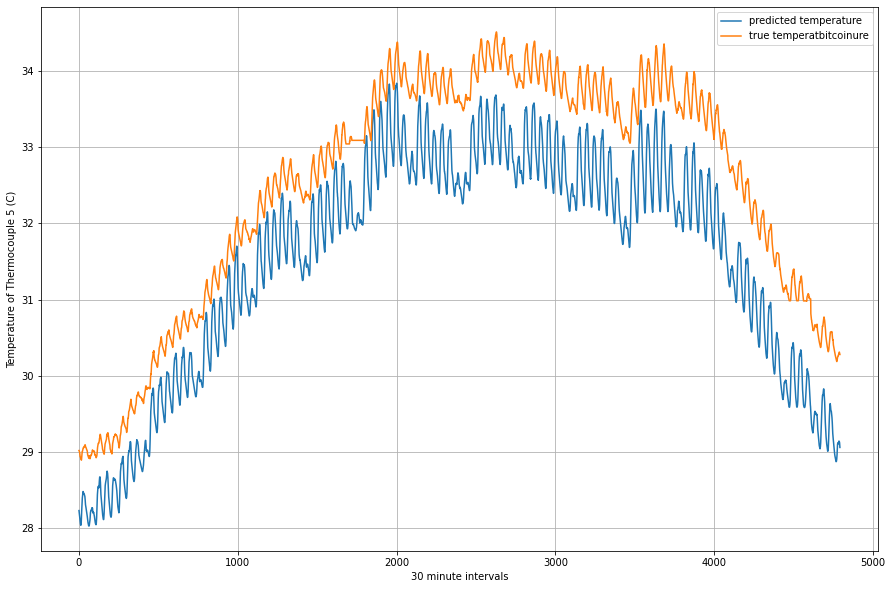

In [ ]:
# make predictions with RNN model
y_preds = make_predictions(rnn_model, test_dataloader, device)
# plot predictions of RNN model
plot_predictions(y_preds, test_data.y)

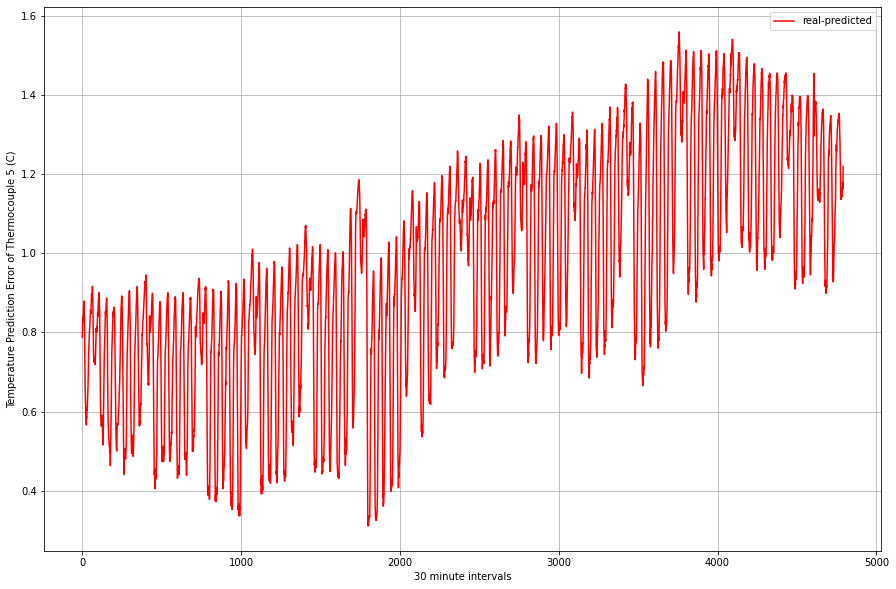

In [ ]:
# plot prediction error of RNN model
plot_predictions_error(y_preds, test_data.y)

### LSTM Model

In [ ]:
# initialize custom model [num_features, hidden_size, output_size, num_layers] and allocate to device
lstm_model = LongShortTermMemoryNetwork(4, 16, 1, 1).to(device)
# print a summary of the model using a generic input shape
summary(lstm_model, input_size=(64, SEQUENCE_LENGTH, 4), col_names=['input_size', 'output_size', 'trainable'], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Trainable
LongShortTermMemoryNetwork               [64, 8, 4]           [64, 1]              True
├─LSTM: 1-1                              [64, 8, 4]           [64, 8, 16]          True
├─Linear: 1-2                            [64, 16]             [64, 1]              True
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
Total mult-adds (M): 0.72
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.08

In [ ]:
# set up loss function
loss_fn = nn.MSELoss()
# set up optimizer
optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=0.01, weight_decay=0.01)

In [ ]:
# run LSTM model and display results
model_1_results = train(lstm_model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=20)

Epoch: 1 | Train Loss: 147.51154 | Test Loss: 163.37544
Epoch: 2 | Train Loss: 18.23884 | Test Loss: 92.35139
Epoch: 3 | Train Loss: 2.19486 | Test Loss: 39.72867
Epoch: 4 | Train Loss: 0.34119 | Test Loss: 27.82118
Epoch: 5 | Train Loss: 0.13020 | Test Loss: 22.90847
Epoch: 6 | Train Loss: 0.06407 | Test Loss: 20.21411
Epoch: 7 | Train Loss: 0.04298 | Test Loss: 18.71494
Epoch: 8 | Train Loss: 0.03510 | Test Loss: 17.61709
Epoch: 9 | Train Loss: 0.03079 | Test Loss: 16.88203
Epoch: 10 | Train Loss: 0.02963 | Test Loss: 16.42459
Epoch: 11 | Train Loss: 0.01962 | Test Loss: 15.81285
Epoch: 12 | Train Loss: 0.02207 | Test Loss: 15.45923
Epoch: 13 | Train Loss: 0.02479 | Test Loss: 14.75809
Epoch: 14 | Train Loss: 0.01820 | Test Loss: 14.80694
Epoch: 15 | Train Loss: 0.01956 | Test Loss: 14.87115
Epoch: 16 | Train Loss: 0.01732 | Test Loss: 14.43983
Epoch: 17 | Train Loss: 0.01438 | Test Loss: 13.83336
Epoch: 18 | Train Loss: 0.02004 | Test Loss: 13.80532
Epoch: 19 | Train Loss: 0.01253 |

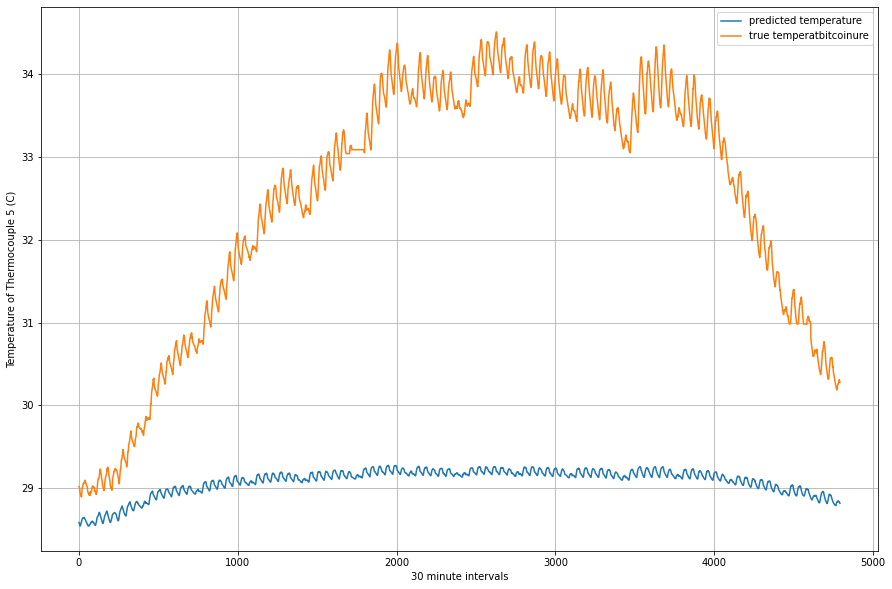

In [ ]:
# make predictions with LSTM model
y_preds = make_predictions(lstm_model, test_dataloader, device)
# plot predictions of LSTM model
plot_predictions(y_preds, test_data.y)

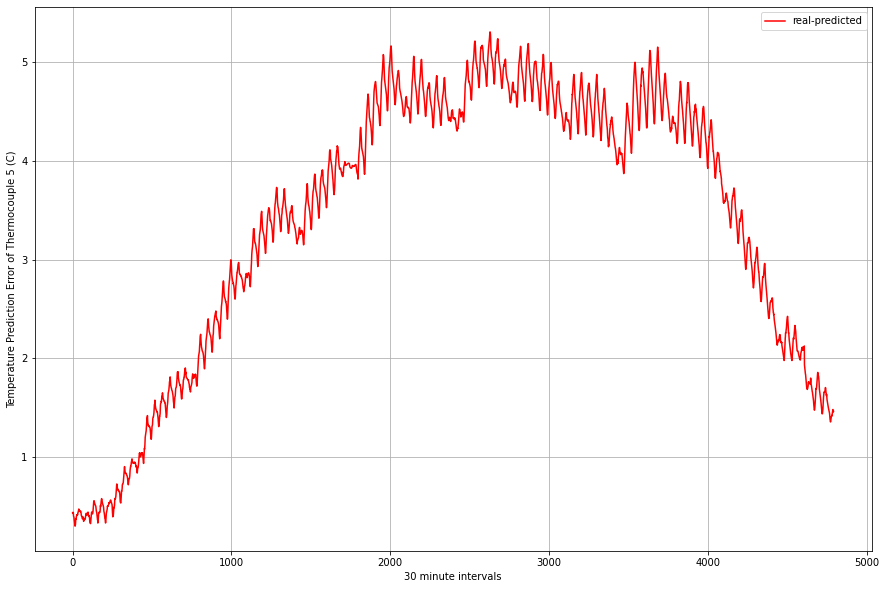

In [ ]:
# plot prediction error of LSTM model
plot_predictions_error(y_preds, test_data.y)

### GRU Model

In [ ]:
# initialize custom model [num_features, hidden_size, output_size, num_layers] and allocate to device
gru_model = GatedRecurrentUnitNetwork(4, 8, 1, 1).to(device)
# print a summary of the model using a generic input shape
summary(gru_model, input_size=(64, SEQUENCE_LENGTH, 4), col_names=['input_size', 'output_size', 'trainable'], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Trainable
GatedRecurrentUnitNetwork                [64, 8, 4]           [64, 1]              True
├─GRU: 1-1                               [64, 8, 4]           [64, 8, 8]           True
├─Linear: 1-2                            [64, 8]              [64, 1]              True
Total params: 345
Trainable params: 345
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04

In [ ]:
# set up loss function
loss_fn = nn.MSELoss()
# set up optimizer
optimizer = torch.optim.Adam(params=gru_model.parameters(), lr=0.01, weight_decay=0.01)

In [ ]:
# run GRU model and display results
model_2_results = train(gru_model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=20)

Epoch: 1 | Train Loss: 240.76695 | Test Loss: 365.91385
Epoch: 2 | Train Loss: 47.12761 | Test Loss: 170.82149
Epoch: 3 | Train Loss: 13.34620 | Test Loss: 92.60598
Epoch: 4 | Train Loss: 3.75949 | Test Loss: 58.71914
Epoch: 5 | Train Loss: 1.34543 | Test Loss: 43.00793
Epoch: 6 | Train Loss: 0.60576 | Test Loss: 34.51029
Epoch: 7 | Train Loss: 0.33496 | Test Loss: 29.35008
Epoch: 8 | Train Loss: 0.21262 | Test Loss: 25.92298
Epoch: 9 | Train Loss: 0.14544 | Test Loss: 23.53258
Epoch: 10 | Train Loss: 0.11092 | Test Loss: 21.60965
Epoch: 11 | Train Loss: 0.07904 | Test Loss: 20.26994
Epoch: 12 | Train Loss: 0.05946 | Test Loss: 19.08871
Epoch: 13 | Train Loss: 0.04908 | Test Loss: 18.31879
Epoch: 14 | Train Loss: 0.03956 | Test Loss: 17.54925
Epoch: 15 | Train Loss: 0.03730 | Test Loss: 16.96602
Epoch: 16 | Train Loss: 0.03262 | Test Loss: 16.40643
Epoch: 17 | Train Loss: 0.03056 | Test Loss: 16.14185
Epoch: 18 | Train Loss: 0.02785 | Test Loss: 15.79817
Epoch: 19 | Train Loss: 0.02774

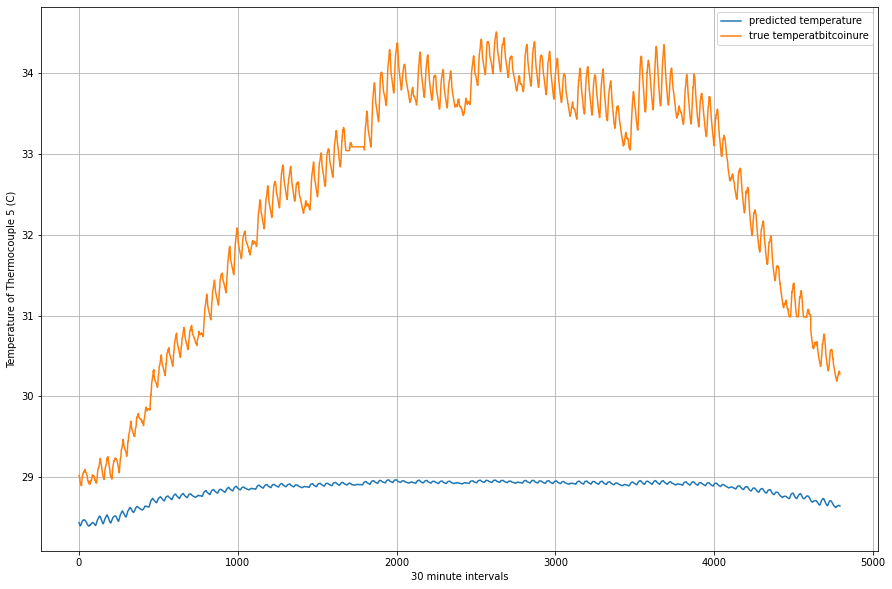

In [ ]:
# make predictions with GRU model
y_preds = make_predictions(gru_model, test_dataloader, device)
# plot predictions of GRU model
plot_predictions(y_preds, test_data.y)

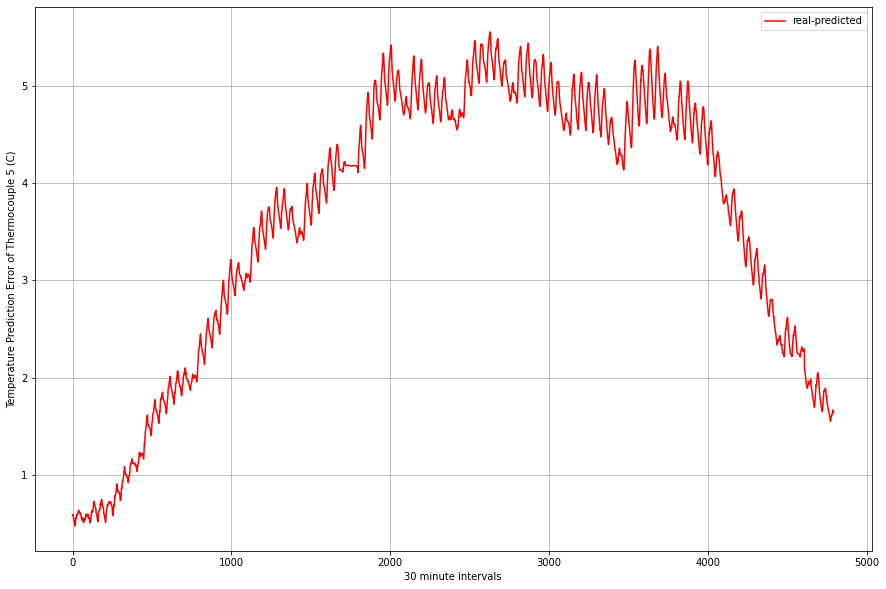

In [ ]:
# plot prediction error of GRU model
plot_predictions_error(y_preds, test_data.y)